<a href="https://colab.research.google.com/github/vadhri/ai-notebook/blob/main/images/data_augmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Data augmentation creates variations of training data to improve model generalization. These variations could be of the or combinations of tranfomations below.
- Linear transformation
  - Rotation
  - Scaling
  - Sheeer
- Translate ( move along axis )

In this notebook, we will start with the dataset of 3 pictures with one dot in each and a label of that metric. The image will start with 20x20 image data with different operations.

Adding batch norm and dropout are strategies to improve generalization and accuracy.

In real scenarios, augementation should happen after dataset split between, test/val/training

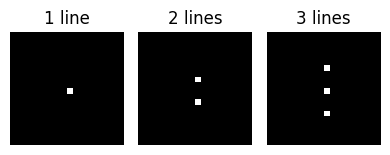

In [1]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

def create_image_with_lines(num_lines, img_size=(20, 20), line_length=1, spacing=3):
    img_array = np.zeros(img_size, dtype=np.uint8)
    center_y = img_size[0] // 2
    center_x = img_size[1] // 2

    total_height = num_lines + (num_lines - 1) * spacing
    start_y = center_y - total_height // 2

    for i in range(num_lines):
        y = start_y + i * (1 + spacing)
        if 0 <= y < img_size[0]:
            for x in range(center_x - line_length // 2, center_x + (line_length + 1) // 2):
                if 0 <= x < img_size[1]:
                    img_array[y, x] = 255

    return Image.fromarray(img_array)

# Generate images for 1, 2, and 3 lines
images = [create_image_with_lines(n) for n in [1, 2, 3]]

# Plot them side by side
plt.figure(figsize=(4, 3))
titles = ['1 line', '2 lines', '3 lines']
for i, img in enumerate(images):
    plt.subplot(1, 3, i+1)
    plt.imshow(img, cmap='gray')
    plt.title(titles[i])
    plt.axis('off')

plt.tight_layout()
plt.show()


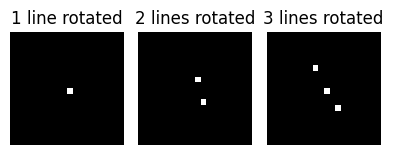

In [2]:
import torchvision.transforms as transforms

rotation_transform = transforms.RandomRotation(degrees=45)
rotated_images = [rotation_transform(img) for img in images]

plt.figure(figsize=(4, 3))
titles = ['1 line rotated', '2 lines rotated', '3 lines rotated']
for i, img in enumerate(rotated_images):
    plt.subplot(1, 3, i+1)
    plt.imshow(np.array(img), cmap='gray')
    plt.title(titles[i])
    plt.axis('off')

plt.tight_layout()
plt.show()


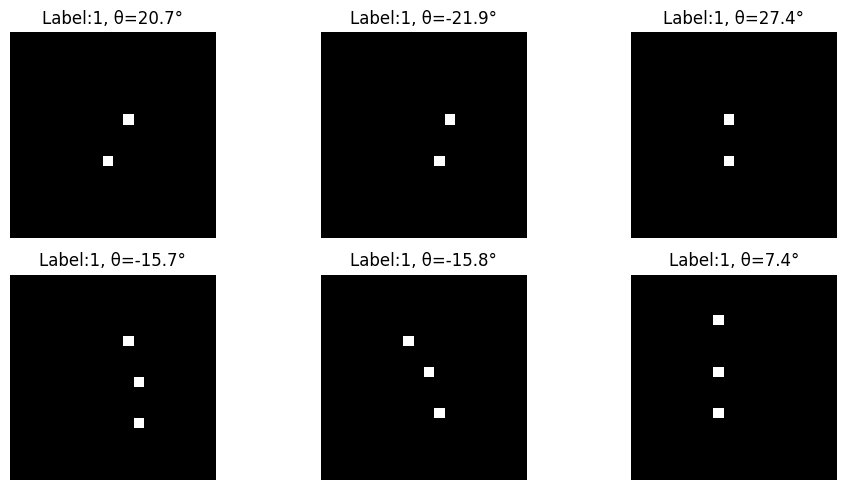

In [3]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import torchvision.transforms.functional as F
import random

# Create augmented dataset
dataset = []
labels = []
rotations = []

crop_size = (20, 20)
samples_per_image = 1000 // 3

for i, img in enumerate(images):
    for j in range(samples_per_image):
        seed = i * samples_per_image + j
        random.seed(seed)

        angle = random.uniform(-30, 30)
        translate = (
            random.uniform(-0.1, 0.1) * img.size[0],
            random.uniform(-0.1, 0.1) * img.size[1]
        )
        scale = random.uniform(0.9, 1.1)

        augmented_img = F.affine(
            img, angle=angle, translate=translate,
            scale=scale, shear=0,
            interpolation=Image.NEAREST, fill=0
        )

        augmented_img = F.resized_crop(
            augmented_img, top=0, left=0,
            height=img.size[1], width=img.size[0],
            size=crop_size,
            interpolation=Image.NEAREST
        )

        dataset.append(np.array(augmented_img))
        labels.append(i + 1)
        rotations.append(angle)

# Display a few examples
plt.figure(figsize=(10, 5))
for i in range(6):
    plt.subplot(2, 3, i+1)
    plt.imshow(dataset[663+i], cmap='gray')
    plt.title(f"Label:{labels[i]}, θ={rotations[i]:.1f}°")
    plt.axis('off')
plt.tight_layout()
plt.show()

In [22]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import torchvision.transforms.functional as F
import random

# Create augmented dataset
val_dataset = []
val_labels = []
rotations = []

crop_size = (20, 20)
samples_per_image = 100 // 3

for i, img in enumerate(images):
    for j in range(samples_per_image):
        seed = i * samples_per_image + j
        random.seed(seed)

        angle = random.uniform(-30, 30)
        translate = (
            random.uniform(-0.1, 0.1) * img.size[0],
            random.uniform(-0.1, 0.1) * img.size[1]
        )
        scale = random.uniform(0.9, 1.1)

        augmented_img = F.affine(
            img, angle=angle, translate=translate,
            scale=scale, shear=0,
            interpolation=Image.NEAREST, fill=0
        )

        augmented_img = F.resized_crop(
            augmented_img, top=0, left=0,
            height=img.size[1], width=img.size[0],
            size=crop_size,
            interpolation=Image.NEAREST
        )

        val_dataset.append(np.array(augmented_img))
        val_labels.append(i + 1)
        rotations.append(angle)

In [5]:
import torch
from torch.utils.data import Dataset, DataLoader

class CustomDataset(Dataset):
    def __init__(self, images, labels):
        self.images = images
        self.labels = labels

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        image = torch.tensor(image, dtype=torch.float32)
        label = torch.tensor(label, dtype=torch.long)
        return image, label

custom_dataset = CustomDataset(dataset, labels)

image, label = custom_dataset[0]
print(f"Image shape: {image.shape}")
print(f"Label: {label}")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dataloader = DataLoader(custom_dataset, batch_size=32, shuffle=True)

Image shape: torch.Size([20, 20])
Label: 1


In [13]:
import torch
import torch.nn as nn
import torch.optim as optim

# Define the neural network architecture with BatchNorm
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(400, 300)
        self.bn1 = nn.BatchNorm1d(300)
        self.relu1 = nn.ReLU()

        self.fc2 = nn.Linear(300, 200)
        self.bn2 = nn.BatchNorm1d(200)
        self.relu2 = nn.ReLU()

        self.fc3 = nn.Linear(200, 128)
        self.bn3 = nn.BatchNorm1d(128)
        self.relu3 = nn.ReLU()

        self.fc4 = nn.Linear(128, 64)
        self.bn4 = nn.BatchNorm1d(64)
        self.relu4 = nn.ReLU()

        self.fc5 = nn.Linear(64, 3)
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        x = x.view(-1, 400)

        x = self.fc1(x)
        x = self.bn1(x)
        x = self.relu1(x)

        x = self.fc2(x)
        x = self.bn2(x)
        x = self.relu2(x)

        x = self.fc3(x)
        x = self.bn3(x)
        x = self.relu3(x)

        x = self.fc4(x)
        x = self.bn4(x)
        x = self.relu4(x)

        x = self.fc5(x)
        x = self.dropout(x)

        return x

net = Net().to(device)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

num_epochs = 1000
for epoch in range(num_epochs):
    for i, data in enumerate(dataloader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels - 1)
        loss.backward()
        optimizer.step()

    if epoch % 100 == 0:
        print(f"Epoch: {epoch+1}, Batch: {i+1}, Loss: {loss.item():.4f}")

print("Training finished!")

Epoch: 1, Batch: 32, Loss: 0.4715
Epoch: 101, Batch: 32, Loss: 1.3325
Epoch: 201, Batch: 32, Loss: 0.0904
Epoch: 301, Batch: 32, Loss: 0.2510
Epoch: 401, Batch: 32, Loss: 0.1247
Epoch: 501, Batch: 32, Loss: 0.2492
Epoch: 601, Batch: 32, Loss: 0.1283
Epoch: 701, Batch: 32, Loss: 0.7685
Epoch: 801, Batch: 32, Loss: 0.0165
Epoch: 901, Batch: 32, Loss: 0.2562
Training finished!


Accuracy of the network on the dataset: 95.80%
Confusion Matrix:


<Axes: >

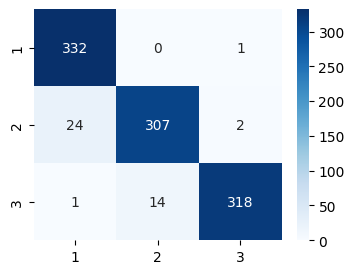

In [28]:
import torch
from sklearn.metrics import confusion_matrix, accuracy_score
import numpy as np

net.eval()

all_predictions = []
all_labels = []

with torch.no_grad():
    for data in dataloader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = net(inputs)
        _, predicted = torch.max(outputs, 1)

        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy() -1)

# Calculate accuracy
accuracy = accuracy_score(all_labels, all_predictions)
print(f"Accuracy of the network on the dataset: {100 * accuracy:.2f}%")

# Compute confusion matrix
cm = confusion_matrix(all_labels, all_predictions)
print("Confusion Matrix:")
cm

#plot confusion matrix
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(4, 3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['1', '2', '3'], yticklabels=['1', '2', '3'])

